In [ ]:

# import library yang dibutuhkan
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
import keras







[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text Classification


# Text Preporcessing
Pada bagian ini kita akan menerapkan praproses teks yang sederhana berupa lowercase, Uppercase, stemmer & Stop word

In [ ]:
# membaca data dari file csv
df = pd.read_csv('/content/data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Lowercase
def lowercase(text):
    return text.lower()

# Hilangkan Tanda Baca
table = str.maketrans("", "", string.punctuation)
def remove_puncts(text):
    return text.translate(table)

# Hilangkan Url
def remove_url(text):
    url = re.compile(r"https?(://\S+|\S+)|www\.\S+")
    return url.sub("", text)

# Praproses Teks
def preprocess_text(text):
    text = lowercase(text)
    text = remove_url(text)
    text = remove_puncts(text)
    return text

In [ ]:
df["Message_cleaned"] = df["Message"].apply(preprocess_text)
df.head()

,Category,Message,Message_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [ ]:
# Membuat fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()  # Mengubah huruf menjadi lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'\s+', ' ', text)  # Menghapus spasi berlebih
    return text

# Membersihkan kolom "Message"
df['Message_cleaned'] = df['Message'].apply(clean_text)

# Mengubah kategori "ham" dan "spam" menjadi nilai biner
df['label'] = np.where(df['Category']=='ham', 0, 1)

# Menghapus kolom kategori "ham" dan "spam" asli
df = df.drop(['Category', 'Message'], axis=1)

# Train-Test Split
Memisahkan data menjadi train-test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Message_cleaned"], df["label"])

# Text Vectorization
Membuat data secara berurutan dan menentukan panjang kalimat menjadi  sama

In [ ]:
# Jumlah panjang kalimat maksimal
maxlen = df["Message_cleaned"].str.split().str.len().max()
maxlen = 30  # Pakai 30 ngikutin tutor biar cpt
maxlen

30

In [ ]:
# Tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)

# Update kosa kata
tokenizer.fit_on_texts(df["Message_cleaned"])

# Ubah teks menjadi sequence
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)


# Samakan panjang kalimat
X_train_sequence = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=maxlen, padding="post")
X_test_sequence = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=maxlen, padding="post")

# X_train_sequence
X_train_sequence.shape


(4179, 30)

# Dasar menggunakan Keras

In [ ]:
inputs = tf.random.normal(shape=(100, 3))
outputs = tf.random.normal(shape=(100, 1))

inputs.shape, outputs.shape

(TensorShape([100, 3]), TensorShape([100, 1]))

In [ ]:
model = tf.keras.models.Sequential()
model.add( tf.keras.layers.Input(shape=(3,)) )
model.add( tf.keras.layers.Dense(16) )
model.add( tf.keras.layers.Dense(1, activation="sigmoid") )


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(inputs, outputs, epochs=1, batch_size=32)

4/4 [==============================] - 1s 6ms/step - loss: 0.9196 - acc: 0.0000e+00


# Modelling
Pemodelan dalam data teks bisa kita lakukan secara bervariasi tergantung jenis layar apa yang akan kita pakai.

In [ ]:
# Parameter Belajar
BATCH_SIZE = 32
EPOCH = 2
EMBEDDING_DIM = 32

# Word Embedding
Kita membuat model NN yang mengubah data teks menjadi vektor kemudian langsung ditersukan ke layar klasifikasi.

Cara membuatnya:

Buat layar Embedding
Ratakan hasil vektor dengan Flatten
Salurkan ke layar klasifikasi.

In [ ]:
# 1. Susun layer
## Model menerima input dengan dimensi ke-2 sebesar "maxlen"
inputs = keras.layers.Input(shape=(maxlen,))

## Tiap elemen dalam dimensi terakhir akan di tanamkan vektor
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)

## Ratakan word embedding
x = keras.layers.Flatten()(x)

## Salurkan ke layer klasifikasi
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# 2. Buat model
model_embed = keras.models.Model(inputs=inputs, outputs=outputs)

# 3. Compile
model_embed.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# 4. Cek struktur model
model_embed.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 32)            320000    
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 961       
                                                                 
Total params: 320,961
Trainable params: 320,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!apt-get install python3.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 21 not upgraded.
Need to get 5,023 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-min

In [ ]:
# Training
history_embedding = model_embed.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
)

Epoch 1/2
105/105 [==============================] - 2s 13ms/step - loss: 0.3749 - binary_accuracy: 0.8657 - val_loss: 0.2301 - val_binary_accuracy: 0.9079
Epoch 2/2
105/105 [==============================] - 1s 11ms/step - loss: 0.1734 - binary_accuracy: 0.9438 - val_loss: 0.1327 - val_binary_accuracy: 0.9653


In [ ]:
def history_line_plot(history, keys, title=""):
    for key in keys:
        plt.plot(history[key], label=key)
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# Melihat daftar metrik
history_embedding.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

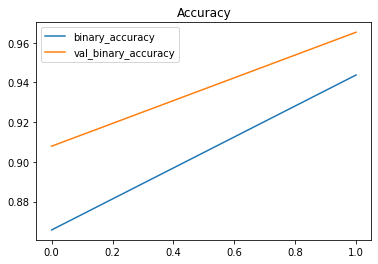

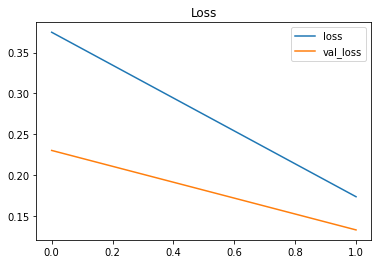

In [ ]:
history_line_plot(
    history=history_embedding.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy"
)

history_line_plot(
    history=history_embedding.history, 
    keys=["loss", "val_loss"],
    title="Loss"
)

# GRU
Kita membuat model GRU yang memiliki daya ingat lebih lemah ketimbang LSTM, namun dengan performa yang lebih cepat dan efisien.

Cara membuatnya:

Buat layar Embedding
Buat layar GRU
Salurkan ke layar klasifikasi.

In [ ]:
# 1. Susun layer
## Model menerima input dengan dimensi ke-2 sebesar "maxlen"
inputs = keras.layers.Input(shape=(maxlen,))

## Tiap elemen dalam dimensi terakhir akan di tanamkan vektor
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)

## Layer GRU memproses kata secara berurutan dan mengeluarkan output pada urutan terakhir
x = keras.layers.GRU(16)(x)

## Salurkan ke layer klasifikasi
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

## catatan kalau klasifikasi multi-class
# outputs = keras.layers.Dense(3, activation="softmax")(x)

# 2. Buat model
model_gru = keras.models.Model(inputs=inputs, outputs=outputs)

# 3. Compile
model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# 4. Cek struktur model
model_gru.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 322,417
Trainable params: 322,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
history_gru = model_gru.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
)

Epoch 1/2
105/105 [==============================] - 6s 29ms/step - loss: 0.4167 - binary_accuracy: 0.8657 - val_loss: 0.2718 - val_binary_accuracy: 0.8768
Epoch 2/2
105/105 [==============================] - 2s 22ms/step - loss: 0.1512 - binary_accuracy: 0.9480 - val_loss: 0.0875 - val_binary_accuracy: 0.9844


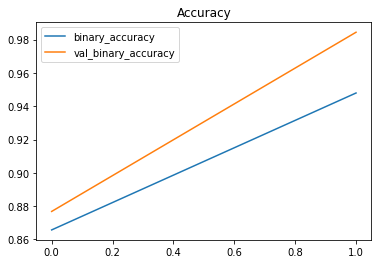

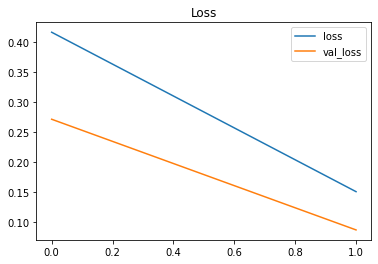

In [ ]:
history_line_plot(
    history=history_gru.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy"
)

history_line_plot(
    history=history_gru.history, 
    keys=["loss", "val_loss"],
    title="Loss"
)

# RNN
Kita membuat model RNN sederhana yang mempelajari urutan dalam suatu data.

Cara membuatnya:

Buat layar Embedding
Buat layar RNN
Salurkan ke layar klasifikasi.

In [ ]:
# 1. Susun layer
## Model menerima input dengan dimensi ke-2 sebesar "maxlen"
inputs = keras.layers.Input(shape=(maxlen,))

## Tiap elemen dalam dimensi terakhir akan di tanamkan vektor
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)

## Layer RNN memproses kata secara berurutan dan mengeluarkan output pada urutan terakhir
## Kalau mau numpuk, bisa pakai return_sequences
# x = keras.layers.SimpleRNN(16, return_sequences=True)(x)
x = keras.layers.SimpleRNN(16)(x)

## Salurkan ke layer klasifikasi
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# 2. Buat model
model_rnn = keras.models.Model(inputs=inputs, outputs=outputs)

# 3. Compile
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# 4. Cek struktur model
model_rnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 30, 32)            320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,801
Trainable params: 320,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
history_rnn = model_rnn.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
)

Epoch 1/2
105/105 [==============================] - 3s 19ms/step - loss: 0.4489 - binary_accuracy: 0.8570 - val_loss: 0.3769 - val_binary_accuracy: 0.8732
Epoch 2/2
105/105 [==============================] - 2s 22ms/step - loss: 0.2836 - binary_accuracy: 0.9034 - val_loss: 0.1943 - val_binary_accuracy: 0.9426


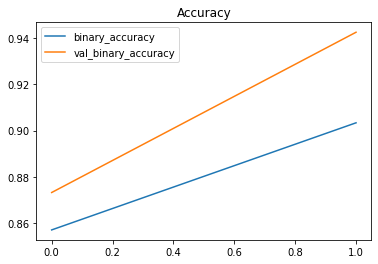

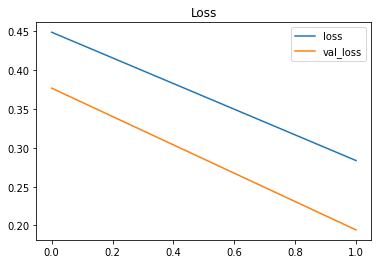

In [ ]:
history_line_plot(
    history=history_rnn.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy"
)

history_line_plot(
    history=history_rnn.history, 
    keys=["loss", "val_loss"],
    title="Loss"
)

# LSTM
Kita membuat model LSTM yang memiliki daya ingat yang melebihi model RNN.

Cara membuatnya:

Buat layar Embedding
Buat layar LSTM
Salurkan ke layar klasifikasi.

In [ ]:
# 1. Susun layer
## Model menerima input dengan dimensi ke-2 sebesar "maxlen"
inputs = keras.layers.Input(shape=(maxlen,))

## Tiap elemen dalam dimensi terakhir akan di tanamkan vektor
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)

## Layer LSTM memproses kata secara berurutan dan mengeluarkan output pada urutan terakhir
x = keras.layers.LSTM(16)(x)

## Salurkan ke layer klasifikasi
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# 2. Buat model
model_lstm = keras.models.Model(inputs=inputs, outputs=outputs)

# 3. Compile
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# 4. Cek struktur model
model_lstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 30, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
history_lstm = model_lstm.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
)

Epoch 1/2
105/105 [==============================] - 5s 25ms/step - loss: 0.3510 - binary_accuracy: 0.8800 - val_loss: 0.1405 - val_binary_accuracy: 0.9629
Epoch 2/2
105/105 [==============================] - 3s 30ms/step - loss: 0.1000 - binary_accuracy: 0.9838 - val_loss: 0.0874 - val_binary_accuracy: 0.9797


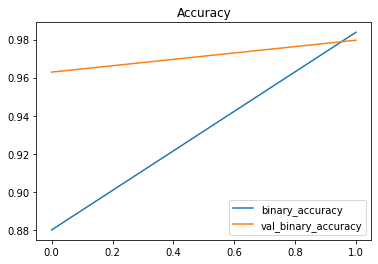

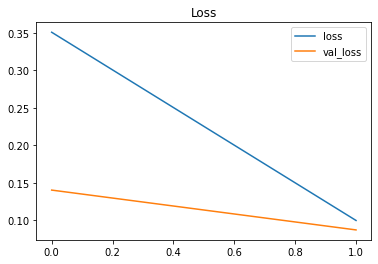

In [ ]:
history_line_plot(
    history=history_lstm.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy"
)

history_line_plot(
    history=history_lstm.history, 
    keys=["loss", "val_loss"],
    title="Loss"
)

#Evaluasi dan Prediksi
Sebagai contoh kita akan menggunakan model dari embedding untuk melakukan prediksi

In [ ]:
# Evaluasi
loss, acc = model_embed.evaluate(X_test_sequence, y_test)
print(f"Model test loss: {loss}")
print(f"Model test acc: {acc}")

44/44 [==============================] - 0s 3ms/step - loss: 0.1195 - binary_accuracy: 0.9698
Model test loss: 0.11947792768478394
Model test acc: 0.9698492288589478


In [ ]:
# Prediksi
def predict(texts, model):
    texts = [preprocess_text(text) for text in texts]
    seq = tokenizer.texts_to_sequences(texts)
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=maxlen, padding="post")
    probs = model.predict(seq)
    return probs


samples = [
           "saya benci kamar ini", 
           "kamar ini nyaman",
           "penginapan rapi, aman dan nyaman"
            ]

probs = predict(samples, model_gru)
predictions = tf.where(probs > 0.5, "Positif", "Negatif")
predictions = tf.squeeze(predictions, axis=-1)

for sample, prob, label in zip(samples, probs, predictions):
    print(f"Kalimat: {sample}")
    print(f"Probabilitas: {prob}")
    print(f"Label: {label.numpy().decode()}")
    print()

1/1 [==============================] - 2s 2s/step
Kalimat: saya benci kamar ini
Probabilitas: [0.01423201]
Label: Negatif

Kalimat: kamar ini nyaman
Probabilitas: [0.01423201]
Label: Negatif

Kalimat: penginapan rapi, aman dan nyaman
Probabilitas: [0.01433552]
Label: Negatif

